In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [2]:
import math
import random
from collections import OrderedDict, deque, namedtuple

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from unityagents import UnityEnvironment

In [3]:
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
SEED = 1
random.seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE, SEED

('cpu', 1)

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


In [7]:
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, dueling, seed):
        super().__init__()
        self.dueling = dueling
        
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        
        if dueling:
            self.adv_in = nn.Linear(32, 32)
            self.adv_out = nn.Linear(32, action_dim)
            self.val_in = nn.Linear(32, 32)
            self.val_out = nn.Linear(32, 1)
        else:
            self.fc_out = nn.Linear(32, action_dim)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        
        if self.dueling:
            adv = F.relu(self.adv_in(x))
            adv = self.adv_out(adv)
            val = F.relu(self.val_in(x))
            val = self.val_out(val)
            #Using the mean advantage value was found 
            #to stablize optimization in the paper
            mean_adv = adv.mean()

            q = val + adv - mean_adv

            return q
        else:
            out = self.fc_out(x)
            return out
    

In [8]:
from copy import deepcopy

class ExpReplay(object):
    ###           Experience Replay object          ###
    ### Code is largely taken from the DRLND Github ###
    def __init__(self, capacity, action_size, batch_size, seed):
        """
        Creates an instance of the memory with capcity
            ARGS:
                capacity(int):= max number of experience 
                    tuples to store in memory
        """
        self.n = capacity
        self.memory = deque(maxlen=capacity)
        self.action_size = action_size
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", 
                                                                "action", 
                                                                "reward", 
                                                                "next_state", 
                                                                "done"]
                                    )
        self.seed = random.seed(seed)
        
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(DEVICE)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(DEVICE)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(DEVICE)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(DEVICE)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(DEVICE)
  
        return (states, actions, rewards, next_states, dones)
    
    def add_experience(self, state, action, reward, next_state, done):
        exp = self.experience(state, action, reward, next_state, done)
        self.memory.append(exp)
    
    def __len__(self):
        return len(self.memory)

    
class Agent(object):
    ### Object to interact with the environment ###
    def __init__(self, batch_size, state_size, action_size, 
                 dueling,
                 lr, gamma, tau,
                 update_freq, seed):
        """
        Initializes an agent with Q-Networks to use Dueling and Double Deep
        Q-Learning
        """
        self.batch_size = batch_size
        self.state_size = state_size
        self.action_size = action_size
        
        self.lr = lr
        self.gamma = gamma # Discount factor
        self.tau = tau # Interpolation factor for updates
        self.update_freq = update_freq
        self.seed = seed
        
        self.q_online = QNetwork(state_size, action_size, dueling, seed).to(DEVICE)
        self.q_target = QNetwork(state_size, action_size, dueling, seed).to(DEVICE)
        
        self.optimizer = optim.Adam(self.q_online.parameters(), lr=lr)
        
        self.memory = ExpReplay(10000, action_size, batch_size, seed)
        self.t = 0 
        
    def act(self, state, epsilon):
        """
        Chooses an action according to the epsilon-greedy policy
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        self.q_online.eval()
        with torch.no_grad():
            act_values = self.q_online(state)
        self.q_online.train()
        
        if random.random() > epsilon:
            return np.argmax(act_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    
    def step(self, state, action, reward, next_state, done):
        """
        Add an experience to the memory and, if applicable, make a
        learning update
        """
        self.memory.add_experience(state, action, reward, next_state, done)
        
        self.t = (self.t + 1) % self.update_freq
        
        #Sample from ERM if enough samples
        if self.t == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)
 
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        
        a_max = torch.argmax(self.q_online(next_states), 1).unsqueeze(1)
        Q_targets = rewards + (self.gamma * (1-dones) * self.q_target(next_states).gather(1, a_max))
        Q_expected = self.q_online(states).gather(1, actions)
        
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update(self.q_target, self.q_online)
    
    def soft_update(self, target_net, online_net):
        for target_param, online_param in zip(target_net.parameters(),
                                              online_net.parameters()
                                             ):
            target_param.data.copy_(self.tau * online_param.data + (1.0-self.tau)*target_param.data)
    

In [9]:
def train(agent, env, n_episodes, max_t):
    """
    Trains the DDPG agent in the Unity environment
        ARGS:
            agent:= object that will interact with the environment
            env:= Unity environment object
            n_episodes(int):= number of episodes to train for
            max_t(int):= maximum number of timesteps the agent can interact
                with the environment
        RETURN:
            list of scores for each episode
    """
    scores = []
    scores_window = deque(maxlen=100)
    
    for e in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        for t in range(max_t):
            #Agent acts and env steps
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            
            #Collect info from env
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            
            #Updates made to variables
            score += reward
            state = next_state
            
            if done:
                break
                
        scores_window.append(score)
        scores.append(score)
        
        if (np.array(scores_window).mean() >= 30.0) and (len(scores) >= 100):
            print(f"Agent solved environment in {e+1} episodes!")
            print(f"\tScore: {round(np.mean(scores_window), 4)}")
            break
            
        if ((e+1) % 50) == 0:
            print(f"Episode {e+1}:\tAverage Reward: {round(np.mean(scores_window),4)}")
            
        if ((e+1) == 300) and (np.mean(scores_window) < 1.0):
            print("Unsatisfactory improvement, ending training...")
            break
            
    return scores

In [10]:
agent = Agent(batch_size=64, 
              state_size=state_size, 
              action_size=action_size, 
              dueling=True,
              lr=0.0005,
              gamma=0.99, 
              tau=(1.0/2500), #*
              update_freq=4,  
              seed=SEED)
#* updates occur every 4 steps and the target network updates
#every 10,000 steps which means that the full update occurs over
#2,500 updates

In [21]:
scores = train(agent=agent, 
               env=env, 
               n_episodes=1800, 
               max_t=1000, 
               epsilon_min=0.05
              )

Episode 50:	Average Reward: -0.04
Episode 100:	Average Reward: 0.23
Episode 150:	Average Reward: 1.29
Episode 200:	Average Reward: 2.87
Episode 250:	Average Reward: 4.2
Episode 300:	Average Reward: 4.51
Episode 350:	Average Reward: 4.18
Episode 400:	Average Reward: 4.98
Episode 450:	Average Reward: 6.65
Episode 500:	Average Reward: 8.06
Episode 550:	Average Reward: 9.59
Episode 600:	Average Reward: 10.23
Episode 650:	Average Reward: 11.0
Episode 700:	Average Reward: 12.57
Agent solved Banana Collector in 711 episodes!
	Score: 13.02


In [22]:
def plot_running_avg(scores, window=100):
    """
    Plots the running average of desired window size
        ARGS:
            scores(list):= list of episodic rewards
            window(int):= size of the window the average will be computed over
    """
    scores = np.array(scores)
    N = len(scores)
    running_avg = np.empty(N)
    
    for t in range(N):
        running_avg[t] = scores[max(0, t-window):t+1].mean()
    
    plt.plot(running_avg)
    plt.title("Running Average ({}) Score".format(window))
    plt.show()

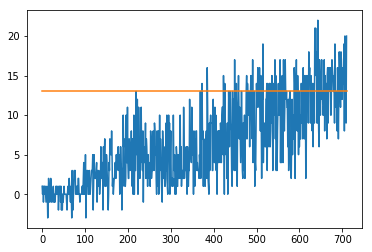

In [24]:
ax = np.arange(0,711)
thresh = np.array([13 for i in range(711)])
plt.plot(ax, scores, ax, thresh)
plt.savefig("dueling_dqn_scores.pdf", dpi=1600)
plt.show()

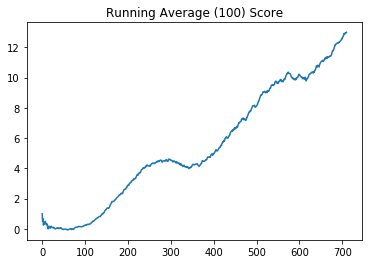

In [25]:
plot_running_avg(scores)

In [26]:
env.close()

In [27]:
torch.save(agent.q_online.state_dict(), 'trained_model.pth')